# Environment

In [130]:
import google.cloud.bigquery as bigquery, pandas as pd, matplotlib.pyplot as plt, seaborn as snsn, \
numpy as np, importlib, math, time 

In [179]:
from multiprocessing import Process

In [2]:
import src.utils.evaluation as evaluation

In [3]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from skmultilearn.problem_transform import LabelPowerset
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    cohen_kappa_score,
)

# Function Definitions

In [72]:
def get_batches(x, y, batch_size=218):
    start_marker = 0
    end_marker = x.shape[0] - (1+218)
    
    while start_marker < end_marker:
        x_chunk = x[start_marker:start_marker+batch_size, :]
        y_chunk = y.iloc[start_marker:start_marker+batch_size]
        yield x_chunk, y_chunk
        start_marker += batch_size
    
    batch_size_final = (x.shape[0] - 1) - end_marker
    x_chunk = x[start_marker:start_marker+batch_size_final, :]
    y_chunk = y.iloc[start_marker:start_marker+batch_size_final]
    return x_chunk, y_chunk

In [170]:
def generate_report(stats):
    duration = time.time() - stats['t0']
    report = '{0}% trained \t | accuracy: {1}'.format(round((stats['n_train']/stats['size'])*100, 1), 
                                                               round(stats['accuracy'], 3))
    return report

# Data

In [4]:
client = bigquery.Client()

In [180]:
query = """
SELECT
  *
FROM
  stackoverflow.posts_preprocessed_selection
WHERE RAND() <= 0.25
"""

In [181]:
df = client.query(query).to_dataframe()

In [182]:
df.head()

,id,title,text_body,code_body,tags
0,6913506,populate cursor rowtype variable,googling find answer try modify oracle sproc c...,myrow my tbl rowtype insert my tbl col1 col2 c...,[oracle]
1,24462758,nav bar little fat bootstrap fit logo,nav bar dose expand irrespective image,class navbar brand href img class brand src,[html5]
2,9292988,user authentication cakephp oracle,fatal error member function quote non object l...,,[oracle]
3,12093378,jquery masonry ajax fetch append item cause im...,image overlap issue masonry ajax append item w...,document ready function var container loops wr...,[ajax]
4,35986173,combine array parent array,trouble help array arr1 arr2 wan output arr,,[arrays]


In [183]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404823 entries, 0 to 1404822
Data columns (total 5 columns):
id           1404823 non-null object
title        1404823 non-null object
text_body    1404823 non-null object
code_body    1404823 non-null object
tags         1404823 non-null object
dtypes: object(5)
memory usage: 1.5 GB


# Training with Mini-Batches

In [213]:
x = df['code_body'] + df['title']
y = df['tags'].apply(lambda row: " ".join(row))

In [214]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=30)

In [215]:
vectorizer = TfidfVectorizer(tokenizer=lambda string: string.split(),
                            ngram_range=(1,1),
                            min_df=20,
                            max_df=0.9)

In [216]:
dtm = vectorizer.fit(x)
dtm_train = dtm.transform(x_train)
dtm_test = dtm.transform(x_test)

In [217]:
mini_batches = get_batches(dtm_train, y_train, 218)

In [218]:
classifier = SGDClassifier(n_jobs=-1)

In [219]:
stats = {'n_train': 0, 'n_train_pos': 0,
         'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
         'runtime_history': [(0, 0)], 'total_fit_time': 0.0, 'size':x_train.shape[0]}

tick = time.time()
total_vect_time += time.time() - tick
cnt = 1

for x_chunk, y_chunk in mini_batches:
    tick = time.time()
    
    classifier.partial_fit(x_chunk, y_chunk, classes=np.unique(y_test))
    
    stats['total_fit_time'] += time.time() - tick
    stats['n_train'] += x_chunk.shape[0] # check
    
    tick = time.time()
    
    stats['accuracy'] = classifier.score(dtm_test, y_test)
    stats['prediction_time'] = time.time() - tick
    acc_history = (stats['accuracy'], stats['n_train'])
    stats['accuracy_history'].append(acc_history)
    run_history = (stats['accuracy'], total_vect_time + stats['total_fit_time'])
    stats['runtime_history'].append(run_history)
    
    if cnt%3 == 0:
        print(generate_report(stats))
    cnt += 1

0.1% trained 	 | accuracy: 0.407
0.1% trained 	 | accuracy: 0.479
0.2% trained 	 | accuracy: 0.512
0.2% trained 	 | accuracy: 0.539
0.3% trained 	 | accuracy: 0.557
0.3% trained 	 | accuracy: 0.573
0.4% trained 	 | accuracy: 0.576
0.5% trained 	 | accuracy: 0.591
0.5% trained 	 | accuracy: 0.593
0.6% trained 	 | accuracy: 0.597
0.6% trained 	 | accuracy: 0.604
0.7% trained 	 | accuracy: 0.607
0.8% trained 	 | accuracy: 0.617
0.8% trained 	 | accuracy: 0.62
0.9% trained 	 | accuracy: 0.626
0.9% trained 	 | accuracy: 0.629
1.0% trained 	 | accuracy: 0.63
1.0% trained 	 | accuracy: 0.633
1.1% trained 	 | accuracy: 0.634
1.2% trained 	 | accuracy: 0.635
1.2% trained 	 | accuracy: 0.639
1.3% trained 	 | accuracy: 0.64
1.3% trained 	 | accuracy: 0.641
1.4% trained 	 | accuracy: 0.643
1.5% trained 	 | accuracy: 0.646
1.5% trained 	 | accuracy: 0.649
1.6% trained 	 | accuracy: 0.65
1.6% trained 	 | accuracy: 0.654
1.7% trained 	 | accuracy: 0.653
1.7% trained 	 | accuracy: 0.658
1.8% trained 	

KeyboardInterrupt: 

In [ ]:
y_pred = classifier.predict(dtm_test)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
evaluation.plot_confusion_matrix(cm=cm, classes=range(1, 6), normalize=True)

In [ ]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_test, y_pred))
print("Cohen's cappa coefficient:", cohen_kappa_score(y_test, y_pred))

# Training without Hyperparameter Tuning

In [220]:
x2 = df['code_body'] + df['title']
y2 = df['tags'].apply(lambda row: ' '.join(row))

In [221]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2, stratify=y2, random_state=30)

In [222]:
estimators2 = [
    ('tfidf', TfidfVectorizer(tokenizer=lambda string: string.split(),
                             min_df=10,
                             max_df=0.75,
                             ngram_range=(1,1))),
    ('clf', SGDClassifier(n_jobs=-1, 
                          early_stopping=True, 
                          class_weight='balanced',
                          alpha=0.001))
]

In [223]:
p2 = Pipeline(estimators2)

In [224]:
score2 = p2.fit(x2_train, y2_train)

In [225]:
y2_pred = p2.predict(x2_test)

In [226]:
print(classification_report(y2_test, y2_pred))

                precision    recall  f1-score   support

          .net       0.29      0.30      0.29      2724
          ajax       0.16      0.67      0.25       599
       android       0.92      0.84      0.88     29196
     angularjs       0.60      0.88      0.72      3743
        arrays       0.21      0.42      0.28       936
       asp.net       0.56      0.50      0.53      4153
   asp.net-mvc       0.51      0.67      0.58      2483
             c       0.64      0.68      0.66      6791
            c#       0.70      0.36      0.48     23224
           c++       0.84      0.64      0.73     16799
           css       0.53      0.79      0.63      4291
      database       0.20      0.39      0.26      1127
        django       0.53      0.84      0.65      2454
       eclipse       0.41      0.72      0.52      1388
         excel       0.51      0.86      0.64      3262
      facebook       0.35      0.91      0.51      1414
         forms       0.09      0.58      0.16  

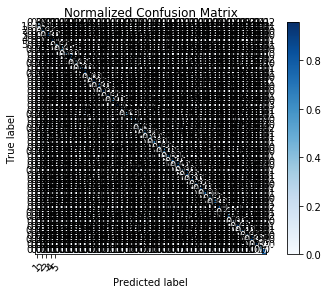

In [227]:
cm2 = confusion_matrix(y2_test, y2_pred)
evaluation.plot_confusion_matrix(cm=cm2, classes=range(1, 6), normalize=True)

In [228]:
print('Accuracy:', accuracy_score(y2_test, y2_pred))
print('Balanced accuracy:', balanced_accuracy_score(y2_test, y2_pred))
print("Cohen's cappa coefficient:", cohen_kappa_score(y2_test, y2_pred))

Accuracy: 0.6302849109319666
Balanced accuracy: 0.6300390259600668
Cohen's cappa coefficient: 0.613501361329076
